<a href="https://www.kaggle.com/code/irynabarnych/ai15-lab?scriptVersionId=171408507" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Завдання:
Ознайомитись з даними та структурою даних
Створіть доповнення(transform) для тренувальних та тестових даних. посилання
Створіть train_dataset та test_dataset за допомогою ImageFolder(може знадобитись ConcatDataset
Створіть train_dataset та test_dataset за допомогою власно написаного Dataset
Візуалізуйте дані
Збережіть kaggle notebook для подальшої роботи

In [1]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])



In [3]:

# Створити екземпляр ImageFolder з трансформаціями
dataset0 = datasets.ImageFolder(root="/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0")
dataset1 = datasets.ImageFolder(root="/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1")
dataset2 = datasets.ImageFolder(root="/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2")
dataset0.classes

['all', 'hem']

In [4]:
dataset = torch.utils.data.ConcatDataset([dataset1, dataset2, dataset0])

In [5]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [7]:
import os
from PIL import Image


class ImageDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading and preprocessing images.
    """
    def __init__(self, root_dir, transform=None, task='Train'):
        """
        Args:
          root_dir (str): Path to the directory containing images.
          transform (torchvision.transforms, optional): Transformations to apply to images. Defaults to None.
        """
        self.root_dir = root_dir
        self.image_paths = self.get_pathes(root_dir, task)

        self.classes = os.listdir(root_dir)
        self.class_to_idx = {label: i for i, label in enumerate(self.classes)}
        self.transform = transform

    def get_pathes(self, root, task):
        image_paths = []
        labels = os.listdir(root)

        for label in labels:
            images = os.listdir(os.path.join(root, label, task))    
            image_paths.extend([os.path.join(root, label, task, image) for image in images])
        return image_paths

    def __len__(self):
        """
        Returns the number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Loads and preprocesses an image at a given index.

        Args:
          idx (int): Index of the image to return.

        Returns:
          tuple: A tuple containing the preprocessed image and its label (if available).
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Assuming RGB images
        if self.transform:
            image = self.transform(image)

        # Add logic to load labels if available (modify based on your data structure)
        label_name = os.path.normpath(image_path).split(os.path.sep)[-3]

        return image, self.class_to_idx[label_name]

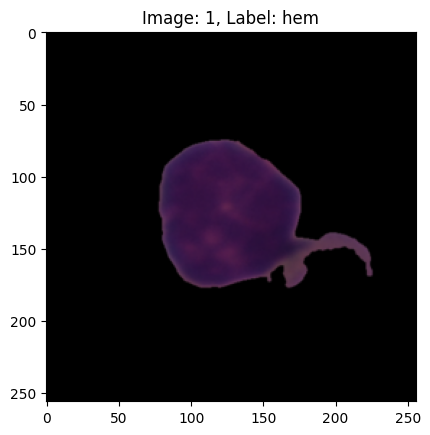

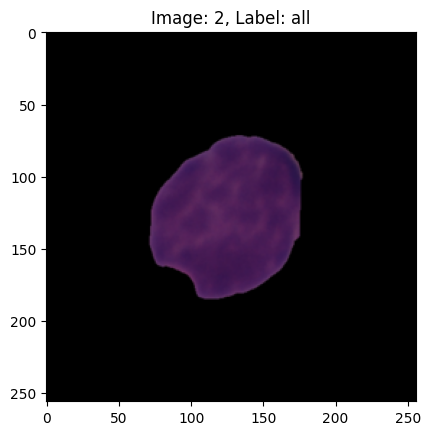

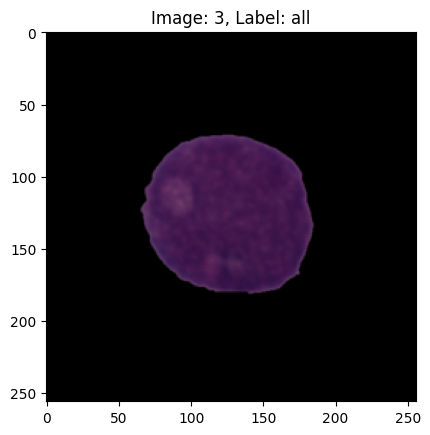

In [8]:
import matplotlib.pyplot as plt

for i in range(3):  # Show 3 images
    img, label = train_data[i]

    # Get the image data (tensor) and convert it back to a NumPy array for manipulation
    img = img.numpy()

    # Convert the color channels from (channels, height, width) to (height, width, channels) for pyplot
    img = img.transpose((1, 2, 0))

    # Get the label name from the dataset class labels
    label_name = dataset0.classes[label]

    # Plot the image with a title (including label name)
    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

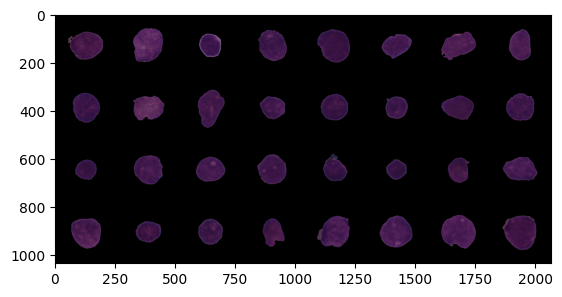

In [9]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0) # результатом є тензор

plt.imshow(grid)

In [10]:
batch_size = 512

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [29]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class FractureClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(32*6*6, 256)
        self.linear2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x - (batch, 3, 256, 256)
        out = self.conv1(x) # (batch, 8, 254, 254)
        out = F.relu(out)
        
        out = self.conv2(out) # (batch, 16, 252, 252)
        out = F.relu(out)
        
        out = self.pool1(out) # (batch, 16, 126, 126)
        
        out = self.conv3(out) # (batch, 32, 124, 124)
        out = F.relu(out)
        
        out = self.pool2(out) # (batch, 32, 62, 62)
        
        out = self.conv4(out) # (batch, 32, 60, 60)
        out = F.relu(out)
        
        out = self.pool3(out) # (batch, 32, 30, 30)
        
        out = self.conv5(out) # (batch, 32, 28, 28)
        out = F.relu(out)
        
        out = self.pool4(out) # (batch, 32, 14, 14)
        
        out = self.conv6(out) # (batch, 32, 12, 12)
        out = F.relu(out)
        
        out = self.pool5(out) # (batch, 32, 6, 6)
        
        out = self.flatten(out) # (batch, 32*6*6)
        
        out = self.linear1(out)
        out = F.relu(out)

        out = self.linear2(out)
        #out = F.softmax(out, dim=-1)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = FractureClassifier(len(dataset0.classes)).to(device)
model

FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=2, bias=True)
)

In [30]:
!pip install -q torchsummary

In [31]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1568 and 1152x256)

In [ ]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

In [ ]:
plot_metric(history, 'accuracy_score')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=test_data.classes)
plt.xticks(rotation=90)
plt.plot()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=test_data.classes))

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        # x - (batch, in_channels, size, size)
        out = self.conv(x) # (batch, out_channels, size, size)
        out = self.bn(out)
        out = F.relu(out)
        #out = self.pool(out) # (batch, out_channels, size//2, size//2)
        out = F.dropout(out, 0.2)
        
        return out

In [ ]:
class BetterClassifier(nn.Module):
    def __init__(self, num_channels=16, num_classes=10):
        super().__init__()
        self.conv_block1 = ConvBlock(3, num_channels)
        self.conv_block2 = ConvBlock(num_channels*1, num_channels*2)
        self.conv_block3 = ConvBlock(num_channels*2, num_channels*4)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = nn.Conv2d(num_channels*4, num_channels, kernel_size=1)
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(num_channels*16*16, 100)
        self.linear2 = nn.Linear(100, num_classes)
        
        self.bn = nn.BatchNorm1d(100)
        

    def forward(self, x):
        # x - (batch, 3, 256, 256)
        out = self.conv_block1(x)   # (batch, num_channels, 128, 128)
        out = self.conv_block2(out) # (batch, num_channels*2, 64, 64)
        out = self.conv_block3(out) # (batch, num_channels*4, 32, 32)
        
        out = self.pool(out) # (batch, num_channels*4, 16, 16)
        out = self.conv(out) # (batch, num_channels, 16, 16) 
        
        out = self.flatten(out) # (batch, num_channels*16*16)
        
        out = self.linear1(out) # (batch, 100)
        #out = self.bn(out)
        out = F.relu(out)
        
        out = self.linear2(out)       # (batch, 10)
        #out = F.softmax(out, dim=-1)  # (batch, 10)
        
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = self.forward(X)

        return y_pred.cpu().numpy()

In [ ]:
model =  BetterClassifier(num_channels=8, num_classes=len(train_data.classes)).to(device)

summary(model, input_size=(3, 256, 256))

In [ ]:
loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

In [ ]:
plot_metric(history, 'loss')

In [ ]:
plot_metric(history, 'accuracy_score')